In [15]:
# Import libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from tensorflow.keras import backend as K

In [18]:
# Directories

In [19]:
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [20]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [24]:
# Visualize sample clean images

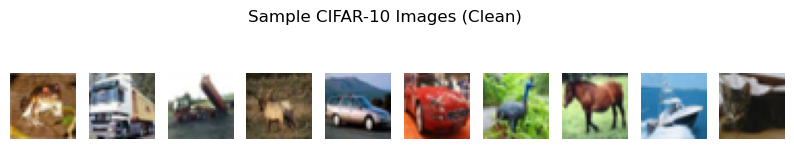

In [25]:
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.suptitle("Sample CIFAR-10 Images (Clean)")
plt.show()

In [26]:
# Add Noise

In [27]:
def add_noise(data, mode='gaussian', var=0.01, amount=0.02):
    if mode == 'gaussian':
        noisy = random_noise(data, mode='gaussian', var=var)
    elif mode == 's&p':
        noisy = random_noise(data, mode='s&p', amount=amount)
    else:
        noisy = data
    noisy = np.clip(noisy, 0., 1.)
    return noisy

x_train_noisy = add_noise(x_train, 'gaussian', 0.01)
x_test_noisy = add_noise(x_test, 'gaussian', 0.01)

In [28]:
# Visualize noisy vs clean

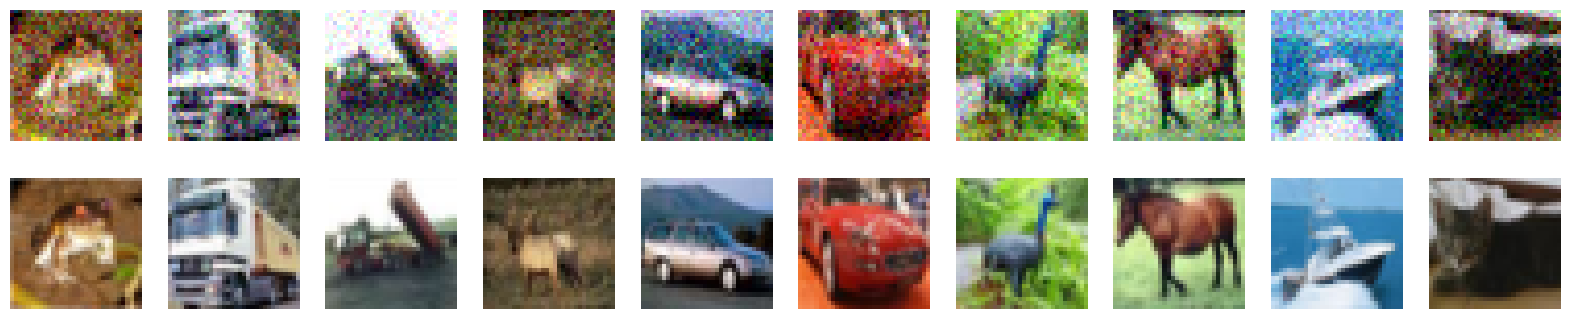

In [30]:
plt.figure(figsize=(20,4))
for i in range(10):
    # Noisy
    ax = plt.subplot(2,10,i+1)
    plt.imshow(x_train_noisy[i])
    plt.axis('off')
    if i==0: plt.ylabel("Noisy")
    # Original
    ax = plt.subplot(2,10,i+11)
    plt.imshow(x_train[i])
    plt.axis('off')
    if i==0: plt.ylabel("Clean")
plt.show()

In [31]:
# Autoecoder

In [33]:
def residual_block(x, filters):
    conv = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    conv = BatchNormalization()(conv)
    conv = Conv2D(filters, (3,3), padding='same', activation='relu')(conv)
    conv = BatchNormalization()(conv)
    out = Add()([x, conv])
    return out

input_img = Input(shape=(32,32,3))

In [34]:
# Encoder

In [35]:
x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = residual_block(x, 64)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

In [36]:
# Decoder

In [37]:
x = Conv2D(128, (3,3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2,2))(x)
x = residual_block(x, 128)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

In [38]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 32, 32, 64)        │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 32, 32, 64)        │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 16, 16, 64)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 16, 16, 64)        │          36,928 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 16, 16, 64)        │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 16, 16, 64)        │          36,928 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 16, 16, 64)        │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 16, 16, 64)        │               0 │ max_pooling2d[0][0],       │
│                               │                           │                 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 16, 16, 128)       │          73,856 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 16, 16, 128)       │             512 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 8, 8, 128)         │               0 │ batch_normalization_3[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 8, 8, 128)         │         147,584 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 8, 8, 128)         │             512 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │               

 Total params: 670,851 (2.56 MB)

 Trainable params: 669,315 (2.55 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [39]:
#Training

In [40]:
checkpoint = ModelCheckpoint("models/denoiser.keras", save_best_only=True)
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 780s 1s/step - loss: 0.0126 - val_loss: 0.0128
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - loss: 0.0038 - val_loss: 0.0034
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 471s 1s/step - loss: 0.0031 - val_loss: 0.0030
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - loss: 0.0026 - val_loss: 0.0026
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 490s 1s/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - loss: 0.0023 - val_loss: 0.0025
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 488s 1s/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 417s 1s/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - loss: 0.0021 - val_loss: 0.0021
Epoch 11/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - loss: 0.0021 - val_loss: 0.0021
Epoch 12/100
391/391 ━━━━━━━━━

In [43]:
# Training curves

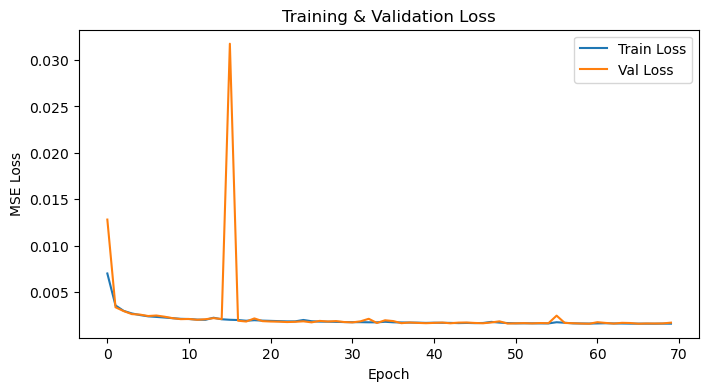

In [44]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [45]:
# Evaluate Denoising

In [49]:
preds = autoencoder.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 18929s 61s/step


In [47]:
# PSNR & SSIM

In [48]:
psnr_values = [psnr(x_test[i], preds[i]) for i in range(len(x_test))]
ssim_values = [ssim(x_test[i], preds[i], multichannel=True) for i in range(len(x_test))]
print("Average PSNR:", np.mean(psnr_values))
print("Average SSIM:", np.mean(ssim_values))

ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

In [ ]:
# PSNR histogram

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(psnr_values, bins=50, color='skyblue')
plt.title("PSNR Distribution on Test Set")
plt.xlabel("PSNR")
plt.ylabel("Count")
plt.show()

In [ ]:
# SSIM histogram

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(ssim_values, bins=50, color='salmon')
plt.title("SSIM Distribution on Test Set")
plt.xlabel("SSIM")
plt.ylabel("Count")
plt.show()

In [ ]:
# Visualize Results

In [ ]:
n = 10
plt.figure(figsize=(20,6))
for i in range(n):
    ax = plt.subplot(3,n,i+1)
    plt.imshow(x_test_noisy[i])
    plt.axis('off')
    if i==0: plt.ylabel("Noisy")
    
    ax = plt.subplot(3,n,i+1+n)
    plt.imshow(preds[i])
    plt.axis('off')
    if i==0: plt.ylabel("Denoised")
    
    ax = plt.subplot(3,n,i+1+2*n)
    plt.imshow(x_test[i])
    plt.axis('off')
    if i==0: plt.ylabel("Original")
plt.savefig("results/denoised_examples.png")
plt.show()